In [52]:
import matplotlib.pyplot as plt
import numpy as np
import math

## hodgkin-huxley model

we're going to first test the capacitor differential equation and see its effect.

i picked up the code from https://www.billconnelly.net/?p=421. i'm gonna try and figure out what's going on here.

In [ ]:
#### CONSTANTS

# Basic simulation Properties
dt     = 10E-6;     # 10 us timestep
 
# Basic Cell Properties
Cm     = 100E-12;   # Membrane Capacitance = 100 pF
v_init = -70E-3;    # Initial membrane potential -70 mV

G_k = 5E-9      # Maximum potassium conductance
Gleak  = 5E-9       # 5 nS conductance
G_na= 7E-6      # Maximum sodium conductance

 
Ek     = -90E-3     # Reversal for HH potassium current
Eleak  = -70E-3     # Reversal potential of -70 mV
Ena    = 40E-3     # Reversal for HH sodium current


# Injected Current step
current_magnitude = 200E-12; # 200 pA
 
#Injected current, 0.2 seconds of 0 current, 0.3 seconds of some current,
#and 0.5 seconds of no current
i_inj = np.concatenate( (np.zeros([round(0.2/dt),1]),
                         current_magnitude*np.ones([round(0.3/dt), 1]),
                         np.zeros([round(0.5/dt), 1])) )


C:\Users\abhim\AppData\Local\Temp\ipykernel_30560\2971398614.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_out[t] = v_out[t-1] + dv; #add dv on to our last known voltage


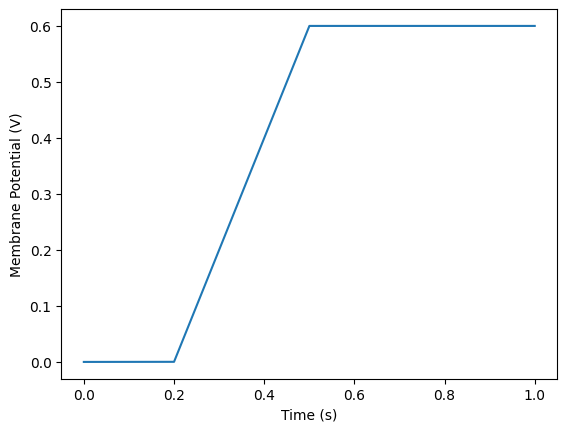

In [ ]:
#Preallocate the voltage output
v_out = np.zeros(np.size(i_inj))

#The real computational meat
for t in range(1, np.size(v_out)):
    if t == 0:
        v_out[t] = v_init; #At the first time step, set voltage to the initial condition
    else:
        i_cap = i_inj[t];   #Calculate what i is
        dv = i_cap/Cm * dt; #Calculate dv, using our favourite equation
        v_out[t] = v_out[t-1] + dv; #add dv on to our last known voltage
 
#Make the graph
t_vec = np.linspace(0, 1, np.size(v_out))
plt.plot(t_vec, v_out)
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.show()


### adding ion channels

so when a neuron gets excited, there's a temporary spike. in the above, we had a spike from 0.2 to 0.6 causing the potential to increase.

because of a lack of ion channels, the spike was permanent, and the change in membrane potential was fixed. why? 

theoretically, from a hodgekin-huxley circuit point of view, because the capacitor potential is increased with the incoming charge, and there's no subsequent discharge, leaving the potential at its fixed level.

practically, the incoming charges causes a permanent charge imbalance between the inside and outside of the membrane, causing a permanently changed potential.

now, we'll add an outgoing ion current through an ion channel.  

C:\Users\abhim\AppData\Local\Temp\ipykernel_30560\1047832037.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_out[t] = v_out[t-1] + dv; #add dv on to our last known voltage


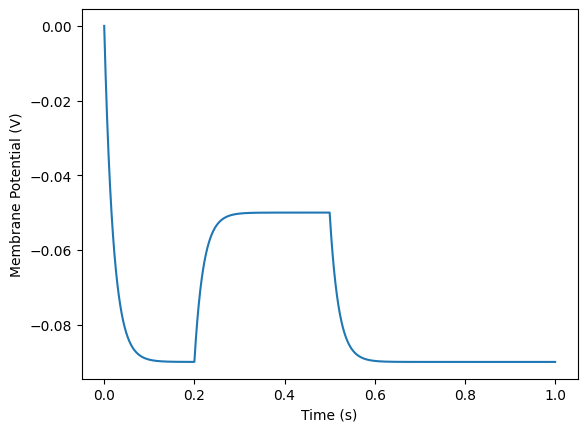

In [ ]:
#Preallocate the voltage output
v_out = np.zeros(np.size(i_inj))

#The real computational meat
for t in range(1, np.size(v_out)):
    if t == 0:
        v_out[t] = v_init; #At the first time step, set voltage to the initial condition
    else:
        i_ion = G_k * (v_out[t-1] - Ek)  #Calculate the current through ion channels
        i_cap = i_inj[t] - i_ion;   #Calculate what i is
        dv = i_cap/Cm * dt; #Calculate dv, using our favourite equation
        v_out[t] = v_out[t-1] + dv; #add dv on to our last known voltage
 
#Make the graph
t_vec = np.linspace(0, 1, np.size(v_out))
plt.plot(t_vec, v_out)
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.show()


why did the membrane potential become constant after the temporary spike?
    
before the input current started, the outgoing ion current was ongoing. this current was a positive ion (K+) going from inside to outside, leaving the potential to become increasingly negative. 

but, at a certain potential, after a sharp decline, the potential became fixed at a constant. here, the potential would've become equal to the Nernst value (-0.09V) i.e. the concentration of K+ became equal outside and inside the cell, and no further movement of ions happened. 

when the input current started, there was some movement of positive charges into the cell. from 0.2 to 0.6, this current motion netted to a certain value of membrane potential.

after the input current stopped, the outgoing current didn't stop, causing a sharp decrease, and then again tending to a constant value - again equal to Nernst value (-0.09V).

### adding k+ gates and leak channels

In [ ]:
def alpha_n(v):
    v = v*1000
    return 0.01 * (-v-55)/( math.exp((-v-55)/10.0) -1) * 1000
 
def beta_n(v):
    v = v*1000
    return 0.125*math.exp((-v-65)/80.0) * 1000

C:\Users\abhim\AppData\Local\Temp\ipykernel_30560\605227801.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_out[t] = v + ((i_cap * dt) / Cm)


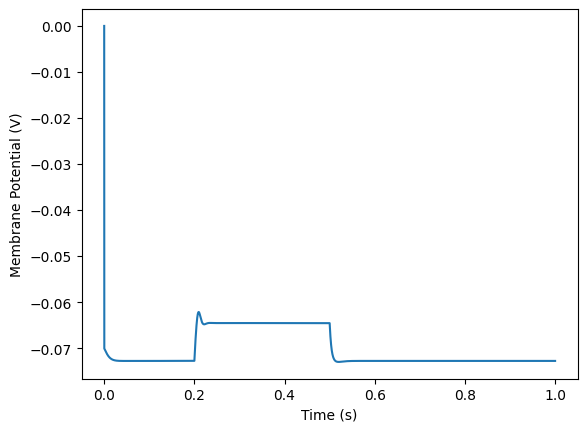

In [67]:
#Preallocate the voltage output
v_out = np.zeros(np.size(i_inj))

for t in range(np.size(v_out)):
    if t == 1:
        v_out[t] = v_init
    else:
        v = v_out[t-1]
        dn = (alpha_n(v) * (1 - n) - beta_n(v) * n) * dt
        n = n + dn

        gk = G_k * n**4
        
        ik = gk * (v - Ek)

        ileak = Gleak * (v - Eleak)

        i_cap = i_inj[t] - ik - ileak

        v_out[t] = v + ((i_cap * dt) / Cm)

#Make the graph
t_vec = np.linspace(0, dt*np.size(v_out), np.size(v_out))
plt.plot(t_vec, v_out)
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.show()

so here we get a slight spike at the start of the current influx. why?

first and foremost, it is important to understand that K+ has a tendency to move outside the cell. why? 

because the nernst potential of k+ is -80mV, and the resting neuron potential is -70mV. this means that while the ions have a general tendency to want to move in via the electric forces (negative potential), the nernst potential (potential formed by the concentration of ions in-vs-out) (potential at which the ions become electrically stable), indicates that the concentration of k+ is high inside the cell as compared to outside.

now, inside a neuron, you have a high concentration of a positive ion, which means repulsion forces. so, you have a force pushing k+ out of the cell (to neutralise the potential between in-vs-out), and you have a resting neuron potential of -70mV trying to pull it back in. because repulsion is greater than attraction (80mV vs 70mV), k+ moves outward.

coming back, you have a leaky bucket of positive charges, causing the potential to grow increasingly negative. now you send a current into this (which is the motion of positive charges into the cell), causing a move towards more positive potential. initially, the k+ channels don't realise what's happening (the openness of ion channels is dependent on the voltage), and still treat the potential as its previously constant value. 

after the holes catch up to what's happening, they increase in value, and the k+ leakage increases, causing a sharp decrease in potential, which then stabilises due to input current and output k+ ions. then the current stops and the equilibrium of k+ ion is achieved again.

### adding na+ ion channels

In [58]:
def alpha_m(v):
    v = v*1000
    return 0.1 * (-v-40)/( math.exp((-v-40)/10.0) -1) * 1000
 
def beta_m(v):
    v = v*1000
    return 4*math.exp((-v-65)/18.0) * 1000
 
def alpha_h(v):
    v = v*1000
    return 0.07*math.exp((-v-65)/20.0) * 1000
 
def beta_h(v):
    v = v*1000
    return 1/( math.exp((-v-35)/10.0) +1) * 1000

In [59]:
m = alpha_m(v_init)/(alpha_m(v_init)+beta_m(v_init))
h = alpha_h(v_init)/(alpha_h(v_init)+beta_h(v_init))

C:\Users\abhim\AppData\Local\Temp\ipykernel_30560\3540824403.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_out[t] = v + dv


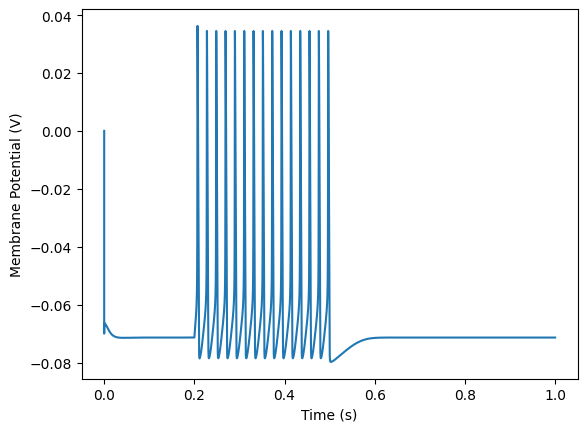

In [68]:
#Preallocate the voltage output
v_out = np.zeros(np.size(i_inj))

for t in range(np.size(v_out)):
    if t == 1:
        v_out[t] = v_init
    else: 
        v = v_out[t-1]

        dn = (alpha_n(v) * (1 - n) - beta_n(v) * n) * dt
        dm = (alpha_m(v) * (1 - m) - beta_m(v) * m) * dt
        dh = (alpha_h(v) * (1 - h) - beta_h(v) * h) * dt

        n = n + dn
        m = m + dm
        h = h + dh

        i_k = G_k * n * n * n * n * (v - Ek)
        i_na = G_na * m * m * m * h * (v - Ena)
        i_leak = Gleak * (v - Eleak)

        i_cap = i_inj[t] - i_k - i_na - ileak

        dv = (i_cap * dt) / Cm

        v_out[t] = v + dv

#Make the graph
t_vec = np.linspace(0, dt*np.size(v_out), np.size(v_out))
plt.plot(t_vec, v_out)
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.show()

notes: 

- first off all, ignore the initial spike in the beginning, that's just happening because the graph is being initiated from t = 1 and not t = 0.

- the na+ gates work on approx the same principle as in k+, so that logic is about the same, probably a little different mathematically.

anyway, we notice that there are spikes (action potentials) when a current is passed into the neuron. why?

na+ is, unlike k+, in high concentration outside the neuron, and has a positive nernst potential (+40mV). this means it wants to come inside. i mean, REALLY wants to come inside. the potential is very high for inward motion. 

now, when there's a current and the membrane potential increases, the na+ gates open (m value), causing sudden influx of na+ ions, causing the spike. 

at this point, the k+ gates (n value) are slow, they realise shifts in potential slowly. when they do get that something shifted, they rush to pull it back to equilibrium, and the na+ gates exponentially close. 

when equilibrium is again reached (momentarily) and the n gates start closing (relaxing a bit), the voltage again increases (the current is still flowing). that is, even a slightly positive shift in voltage causes an insane reaction from na+ gates, and the whole loop starts again.